In [1]:
class TreeNode(object):
    '''
    A class for describing a decision tree node. 
    
    :param X, y: features and labels of samples contained in current node
    :param isLeaf: whether current node is leaf node or not
    :param split_feature, split_value: feature and critical value used to devide subnodes
    :param childs: list of subnodes. usually have 2. 
    :param info: further information discribing current node. Format is (node depth, current 
        impurity, (size of 1st childnode, size of 2nd child node)
    :param classes: list of sample classes contained in current node
    :param class_: Mode of classes. The overall class of current node
    '''
    def __init__(self, X, y, childs=[], info=None, isLeaf=True, split_feature=None, split_value=None):
        self.X = X
        self.y = y
        self.isLeaf = isLeaf
        self.split_feature = split_feature
        self.split_value = split_value
        self.childs = childs
        self.info = info
        self.classes = np.unique(y)
        counter=[]  # temp parameter for class calculation
        for c in self.classes:
            counter.append(np.sum(y==c))
        self.class_ = self.classes[np.argmax(counter)]
    
    def predict_single(self, X):
        '''
        presict the class for single sample
        X: feature array for the single sample
        '''
        if self.isLeaf:
            return self.class_
        else:
            if ((type(self.split_value) == int) | (type(self.split_value) == float)):
                if (X[self.split_feature] >= self.split_value):
                    return self.childs[0].predict_single(X)
                else:
                    return self.childs[1].predict_single(X)
            else:
                if (X[self.split_feature] == self.split_value):
                    return self.childs[0].predict_single(X)
                else:
                    return self.childs[1].predict_single(X)
    
    def predict(self, X):
        '''
        predict the classes for an nparray of samples
        X: feature matrix for the group of samples
        '''
        if len(X.shape) > 0:
            y_temp = []
            for i in range(X.shape[0]):
                y_temp.append(self.predict_single(X[i]))
            return np.array(y_temp)
        else:
            return self.predict_single(X)

In [2]:
import numpy as np
class DecisionTree(object):
    '''
    To build a decision tree based on a set of training data.
    
    :param max_depth: maximum depth for the decision tree
    :param min_gain: minimum gain for each division
    :param impurity_mode: impurity calculate mode. Can choose from 'gini', 'entropy', 'ce'
    :param root: tree root node.
    :param feature index: to pick features to develop current tree
    '''
    def __init__(self, impurity_mode='gini', max_depth=5, min_gain=0.0):
        self.max_depth = max_depth
        self.min_gain = min_gain
        self.impurity_mode = impurity_mode
        
    def impurity(self, y):
        if self.impurity_mode == 'gini':
            return self.gini(y)
        elif self.impurity_mode == 'entropy':
            return self.entropy(y)
        else:
            return self.classification_error(y)
        
    def gini(self, t):  # gini impuruty
        _, tags_count = np.unique(t, return_counts = True)
        prob = tags_count / tags_count.sum()
        ig = 1- np.sum(prob**(2))
        return ig 
    
    def entropy(self, t):
        _, tags_count = np.unique(t, return_counts = True)
        prob = tags_count / tags_count.sum()
        return sum(prob * -np.log2(prob))       
    
    def classification_error(self, t):
        tags = np.unique(t)
        prob = []
        for tag in tags:
            prob.append(np.sum(t==tag)/len(t))
        return 1-max(prob)
    
    def split(self, X, y, feature, value):  # binary split
        n_child = 2
        cX, cy = [], []
        childnode_X, childnode_y = [], []
        for _ in range(n_child):
            cX.append([])
            cy.append([])
        if ((type(value) == int) | (type(value) == float)):
            for i in range(X.shape[0]):
                if (X[i, feature] >= value):
                    cX[0].append(X[i])
                    cy[0].append(y[i])
                else:
                    cX[1].append(X[i])
                    cy[1].append(y[i])
        else:
            for i in range(X.shape[0]):
                if (X[i, feature] == value):
                    cX[0].append(X[i])
                    cy[0].append(y[i])
                else:
                    cX[1].append(X[i])
                    cy[1].append(y[i])
        for i in range(n_child):
            childnode_X.append(np.array(cX[i]))
            childnode_y.append(np.array(cy[i]))
        return childnode_X, childnode_y
    
    def build_decision_tree(self, X, y, depth=0):
        if depth==0:
            self.root = self.build_decision_tree(X, y, depth=1)
        else:
            impurity_current = self.impurity(y)
            gain_best, feature_best, value_best, child_best_X, child_best_y = 0.0, None, None, None, None
        
            n_features = X.shape[1]
            for feature in range(n_features):
                values_ = np.unique(X[:, feature])
                for value in values_:
                    childnode_X, childnode_y = self.split(X, y, feature, value)
                    p = len(childnode_y[0])/len(y)
                    info_gain = impurity_current - p * self.impurity(childnode_y[0]) - (1-p) * self.impurity(childnode_y[1])
                    if info_gain > gain_best:
                        gain_best, feature_best, value_best = info_gain, feature, value
                        child_best_X, child_best_y = childnode_X, childnode_y
        
            if gain_best > self.min_gain:
                info = (depth, impurity_current, (len(child_best_y[0]), len(child_best_y[1])))
                isnotLeaf = (depth <= self.max_depth) & (len(child_best_y[0])>0) & (len(child_best_y[1])>0)
                if isnotLeaf:
                    childs = []
                    for i in range(2):
                        childs.append(self.build_decision_tree(child_best_X[i], child_best_y[i], depth+1))
                    return TreeNode(X=X, y=y, childs=childs, info=info, isLeaf=False, split_feature=feature_best, split_value=value_best)
                else:
                    return TreeNode(X=X, y=y, info=info, isLeaf=True)
            else:
                return TreeNode(X=X, y=y, info=(depth, impurity_current, (-1, -1)), isLeaf=True)

    def set_feature_index(self, feature_index):
        self.feature_index = feature_index
    
    def predict_single(self, X):
        return self.root.predict_single(X)
    
    def predict(self, X):
        return self.root.predict(X)

In [3]:
import numpy as np
import pandas as pd
import random
class RandomForest(object):
    '''
    class for develop a random froest. 
    
    :param n_estimation: number of decision trees in the system. 
    :param feature_percentage: proportion of features chosed for each tree. Usually low.
    :param sample_percentage: proportion of training samples number and total sample number. Usually close to 1. 
    :param impurity_mode: impurity calculate mode
    :param max_depth: maximum depth for the decision tree
    :param min_gain: minimum gain for each division
    :param showProcess: whether print sample number and feature number in each training to show the process
    :param trees: list of trees in the forset
    '''
    def __init__(self, n_estimation=100, feature_percentage=0.3, sample_percentage=0.95, impurity_mode='gini', max_depth=8, min_gain=0.0, showProcess=False):
        self.n_estimation = n_estimation
        self.feature_percentage = feature_percentage
        self.sample_percentage = sample_percentage
        self.trees = []
        self.impurity_mode = impurity_mode
        self.max_depth = max_depth
        self.min_gain = min_gain
        self.showProcess = showProcess
        
    def sample(self, X, y):
        sample_index = []
        X_sample = []
        y_sample = []
        feature_index = np.random.choice(range(0, X_train.shape[1]), self.n_feature)
        feature_index.sort()
        for _ in range(self.n_sample):
            i = np.random.randint(0, X_train.shape[0])
            sample_index.append(i)
            x_temp = []
            for j in range(self.n_feature):
                x_temp.append(X_train[i][j])
            X_sample.append(np.array(x_temp))
            y_sample.append(y_train[i])
        return np.array(X_sample), np.array(y_sample), feature_index
    
    def fit(self, X, y):
        self.n_sample = int(X.shape[0]*self.sample_percentage)
        self.n_feature = int(X.shape[1]*self.feature_percentage)
        if self.showProcess:
            print("sample number:", self.n_sample, "feature number:", self.n_feature)
        if (self.n_sample <= 0) | (self.n_feature<0):
            print("illegal setting")
            return
        for i in range(self.n_estimation):
            tree=DecisionTree(impurity_mode=self.impurity_mode, max_depth=self.max_depth, min_gain=self.min_gain)
            X_sample, y_sample, feature_index = self.sample(X, y)
            tree.set_feature_index(feature_index)
            tree.build_decision_tree(X_sample, y_sample)
            # print(tree.root.info)
            self.trees.append(tree)
    
    def predict_single(self, X):
        y_pred = []
        for tree in self.trees:
            X_proc = []
            for i in range(len(tree.feature_index)):
                X_proc.append(X[tree.feature_index[i]])
            y_pred.append(tree.predict_single(np.array(X_proc)))
        classes = np.unique(y_pred)
        counter=[]
        for c in classes:
            counter.append(np.sum(y_pred==c))
        return classes[np.argmax(counter)]
    
    def predict(self, X):
        if len(X.shape) > 0:
            y_temp = []
            for i in range(X.shape[0]):
                y_temp.append(self.predict_single(X[i]))
            return np.array(y_temp)
        else:
            return self.predict_single(X)
        

In [8]:
import numpy as np
import pandas as pd  
labels = ['vgood', 'good', 'acc', 'unacc']
buying_mapping = {'vhigh': 4, 'high': 3, 'med': 2, 'low': 1}
maint_mapping = {'vhigh': 4, 'high': 3, 'med': 2, 'low': 1}
doors_mapping = {'5more': 5, '4': 4, '3': 3, '2': 2, '1': 1} 
persons_mapping = {'more': 3, '4': 2, '2': 1}
lug_boot_mapping = {'big': 3, 'med': 2, 'small': 1}
safety_mapping = {'high': 3, 'med': 2, 'low': 1}

class_mapping = {'vgood': 3, 'good': 2, 'acc': 1, 'unacc': 0}

df_trainX = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/car_X_train.csv", header=0, error_bad_lines=False)
df_trainy = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/car_y_train.csv", header=0, error_bad_lines=False)
df_testX = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/car_X_test.csv", header=0, error_bad_lines=False)
df_testy = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/car_y_test.csv", header=0, error_bad_lines=False)

for df in (df_trainX, df_testX):
    df['buying'] = df['buying'].map(buying_mapping)
    df['maint'] = df['maint'].map(maint_mapping)
    df['doors'] = df['doors'].map(doors_mapping)
    df['persons'] = df['persons'].map(persons_mapping)
    df['lug_boot'] = df['lug_boot'].map(lug_boot_mapping)
    df['safety'] = df['safety'].map(safety_mapping)
for df in (df_trainy, df_testy):
    df['class'] = df['class'].map(class_mapping)
X_train = df_trainX.iloc[:].values
y_train = df_trainy.iloc[:, 0].values 
X_test = df_testX.iloc[:].values
y_test = df_testy.iloc[:, 0].values

markers = ('o', 'x', 's', '^', 'v')
colors = (('lightcoral', 'lightsteelblue', 'lightgreen', 'gold', 'thistle', 'silver'),('red', 'blue', 'green', 'darkorange', 'darkviolet', 'dimgray'))
labels = np.unique(y_train)

In [9]:
rf = RandomForest(n_estimation=100, sample_percentage=0.95, feature_percentage=0.25, max_depth=10, showProcess=False)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
test_error=(y_test!=y_pred).sum()
y_pred = rf.predict(X_train)
train_error=(y_train!=y_pred).sum()
print(train_error/len(y_train), test_error/len(y_test))

0.29528535980148884 0.31021194605009633


sample number: 604 feature number: 1
sample number: 604 feature number: 1
sample number: 604 feature number: 1
sample number: 604 feature number: 1
sample number: 604 feature number: 1
sample number: 604 feature number: 2
sample number: 604 feature number: 2
sample number: 604 feature number: 2
sample number: 604 feature number: 2
sample number: 604 feature number: 2
sample number: 604 feature number: 3
sample number: 604 feature number: 3
sample number: 604 feature number: 3
sample number: 604 feature number: 3
sample number: 604 feature number: 3
sample number: 604 feature number: 4
sample number: 604 feature number: 4
sample number: 604 feature number: 4
sample number: 604 feature number: 4
sample number: 604 feature number: 4
sample number: 604 feature number: 6
sample number: 604 feature number: 6
sample number: 604 feature number: 6
sample number: 604 feature number: 6
sample number: 604 feature number: 6
sample number: 906 feature number: 1
sample number: 906 feature number: 1
s

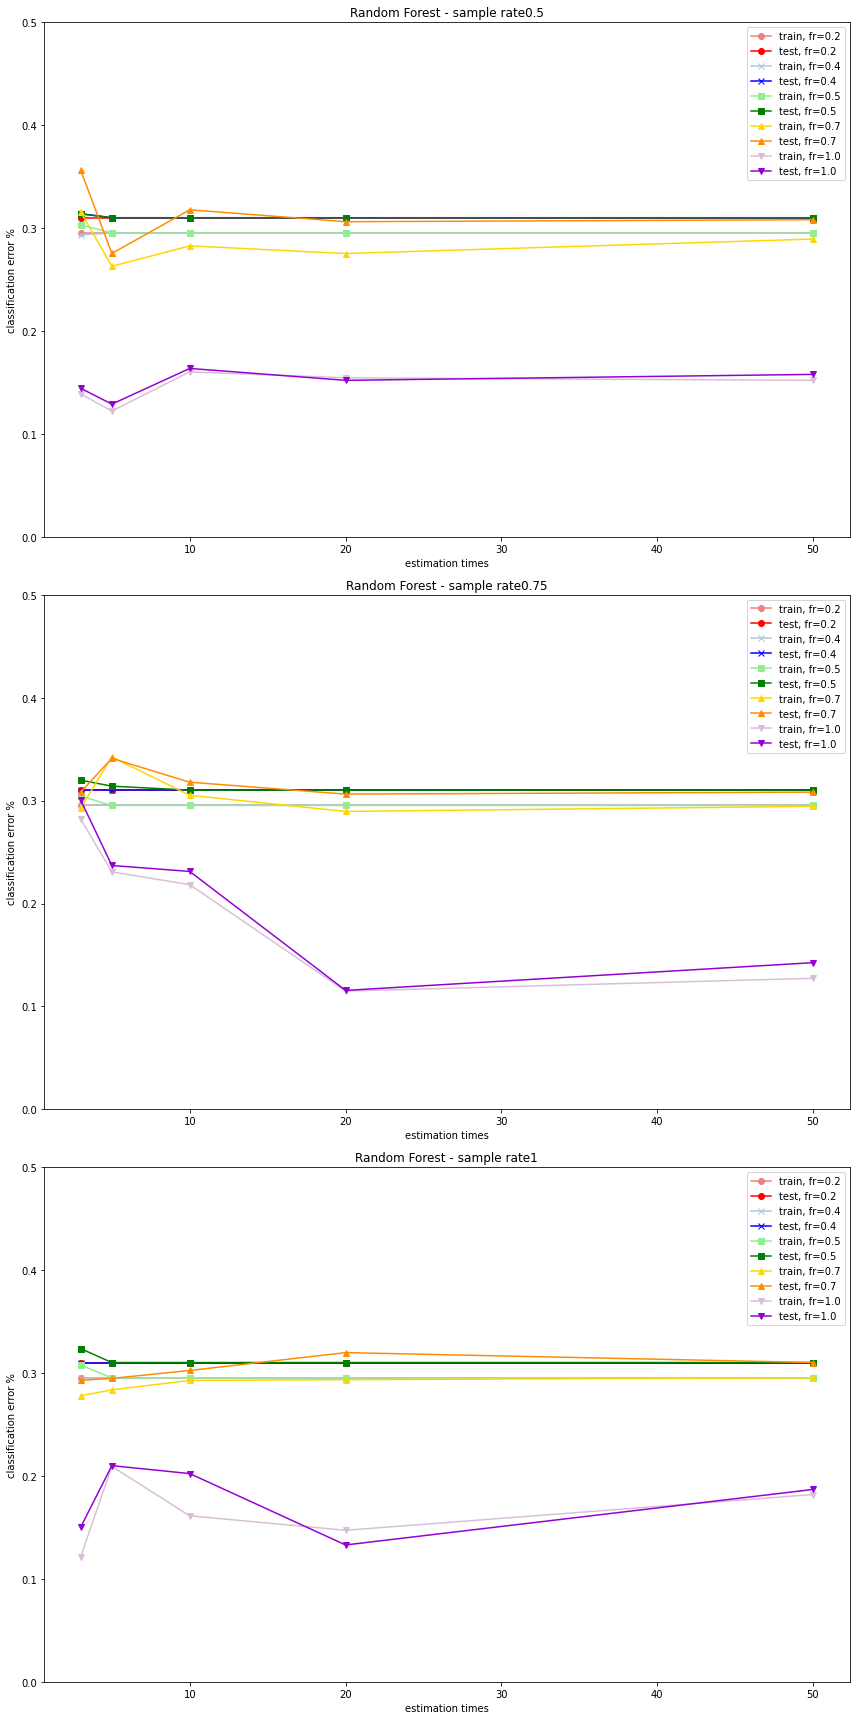

In [10]:
import matplotlib.pyplot as plt
rows, cols=3, 1
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12*cols, 8*rows))
sample_perc = [0.5, 0.75, 1]
feature_perc = [0.2, 0.4, 0.5, 0.7, 1.0]
estimation = [3, 5, 10, 20, 50]
for i in range(rows):
    for j in range(5):
        test_error=[]
        train_error=[]
        for k in range(5):
            rf = RandomForest(n_estimation=estimation[k], sample_percentage=sample_perc[i], feature_percentage=feature_perc[j], max_depth=10, showProcess=True)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            test_error.append((y_test!=y_pred).sum()/len(y_test))
            y_pred = rf.predict(X_train)
            train_error.append((y_train!=y_pred).sum()/len(y_train))
        ax[i].plot(estimation, train_error, marker=markers[j], color=colors[0][j], label="train, fr="+str(feature_perc[j]))
        ax[i].plot(estimation, test_error, marker=markers[j], color=colors[1][j], label="test, fr="+str(feature_perc[j]))
    ax[i].set_xlabel('estimation times')
    ax[i].set_ylabel('classification error %')
    ax[i].set_xlabel('estimation times')
    ax[i].set_ylabel('classification error %')
    ax[i].set_ylim(0, 0.5)
    ax[i].set_title('Random Forest - sample rate'+str(sample_perc[i]))
    ax[i].legend(loc='upper right')
plt.tight_layout() 
plt.show()

In [7]:
df_trainX = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/iris_X_train.csv", header=0, error_bad_lines=False)
df_trainy = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/iris_y_train.csv", header=0, error_bad_lines=False)
df_testX = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/iris_X_test.csv", header=0, error_bad_lines=False)
df_testy = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/iris_y_test.csv", header=0, error_bad_lines=False)

X_train = df_trainX.iloc[:].values
y_train = df_trainy.iloc[:, 0].values 
X_test = df_testX.iloc[:].values
y_test = df_testy.iloc[:, 0].values
labels = np.unique(y_train)

rf1 = RandomForest(n_estimation=200, sample_percentage=1, feature_percentage=0.6, max_depth=10, showProcess=True)
rf1.fit(X_train, y_train)

y_pred = rf1.predict(X_test)
test_error=(y_test!=y_pred).sum()
y_pred = rf1.predict(X_train)
train_error=(y_train!=y_pred).sum()
print(train_error/len(y_train), test_error/len(y_test))

sample number: 100 feature number: 2
0.45 0.54


sample number: 604 feature number: 1
sample number: 604 feature number: 1
sample number: 604 feature number: 1
sample number: 604 feature number: 1
sample number: 604 feature number: 1
sample number: 604 feature number: 2
sample number: 604 feature number: 2
sample number: 604 feature number: 2
sample number: 604 feature number: 2
sample number: 604 feature number: 2
sample number: 604 feature number: 3
sample number: 604 feature number: 3
sample number: 604 feature number: 3
sample number: 604 feature number: 3
sample number: 604 feature number: 3
sample number: 604 feature number: 4
sample number: 604 feature number: 4
sample number: 604 feature number: 4
sample number: 604 feature number: 4
sample number: 604 feature number: 4
sample number: 604 feature number: 6
sample number: 604 feature number: 6
sample number: 604 feature number: 6
sample number: 604 feature number: 6
sample number: 604 feature number: 6
sample number: 906 feature number: 1
sample number: 906 feature number: 1
s

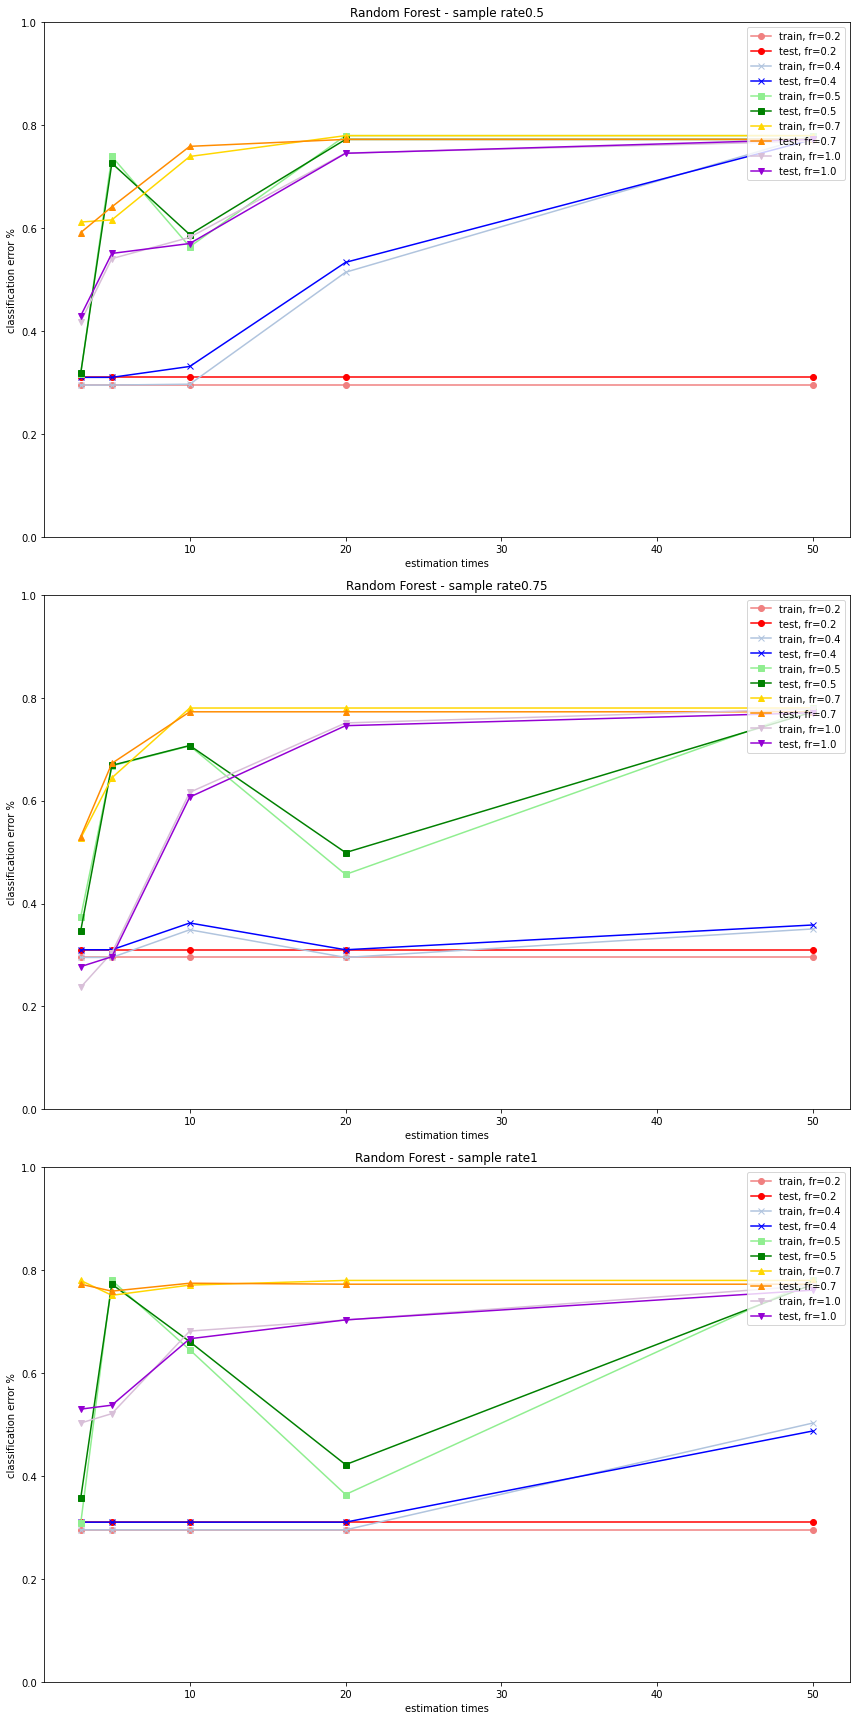

In [12]:
df_trainX = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/car_X_train.csv", header=0, error_bad_lines=False)
df_trainy = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/car_y_train.csv", header=0, error_bad_lines=False)
df_testX = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/car_X_test.csv", header=0, error_bad_lines=False)
df_testy = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/car_y_test.csv", header=0, error_bad_lines=False)

X_train = df_trainX.iloc[:].values
y_train = df_trainy.iloc[:, 0].values 
X_test = df_testX.iloc[:].values
y_test = df_testy.iloc[:, 0].values

labels = np.unique(y_train)

import matplotlib.pyplot as plt
rows, cols=3, 1
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12*cols, 8*rows))
sample_perc = [0.5, 0.75, 1]
feature_perc = [0.2, 0.4, 0.5, 0.7, 1.0]
estimation = [3, 5, 10, 20, 50]
for i in range(rows):
    for j in range(5):
        test_error=[]
        train_error=[]
        for k in range(5):
            rf = RandomForest(n_estimation=estimation[k], sample_percentage=sample_perc[i], feature_percentage=feature_perc[j], max_depth=10, showProcess=True)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            test_error.append((y_test!=y_pred).sum()/len(y_test))
            y_pred = rf.predict(X_train)
            train_error.append((y_train!=y_pred).sum()/len(y_train))
        ax[i].plot(estimation, train_error, marker=markers[j], color=colors[0][j], label="train, fr="+str(feature_perc[j]))
        ax[i].plot(estimation, test_error, marker=markers[j], color=colors[1][j], label="test, fr="+str(feature_perc[j]))
    ax[i].set_xlabel('estimation times')
    ax[i].set_ylabel('classification error %')
    ax[i].set_xlabel('estimation times')
    ax[i].set_ylabel('classification error %')
    ax[i].set_ylim(0, 1.0)
    ax[i].set_title('Random Forest - sample rate'+str(sample_perc[i]))
    ax[i].legend(loc='upper right')
plt.tight_layout() 
plt.show()